In [3]:
import pandas as pd
from openpyxl import load_workbook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')
#pd.reset_option('display.max_columns')

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE, SelectFromModel, SelectKBest, chi2
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesRegressor, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, RandomForestRegressor
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

from lightgbm import LGBMClassifier

### SARS COV1

Notebook for parsing previously obtained structural descriptors using _Modrdred_ and subsequently fitting ML models to predict IC50 values.

**IC50 values**: In micromolar, not pIC50.

## Isatin fret

A congeneric series of the ligands 4{b..z}. Sample size = 15.

1. Data ensembling
2. Non-applying descriptors
    - **Correlation drop (>0.8)**
3. Train/test split - 60/40
    - **IC50 0/1 encoding (7)**
4. Feature selection
    - Pearson correlation
    - LASSO (l2)
    - **RFE-CV - RF**
    - RFE - SVC
    - Light gradient boosting
5. ML model
    - **SVC**
    - **SVR**
    - Neural net
    - Gradient boosing classifier
    - XGBoost classifier
    

    

### Data ensembling

In [85]:
descriptor_df = pd.read_excel('isatin_fret_final_descriptors.xlsx', None)
all_ligand_descriptors = []
for key in descriptor_df.keys():
    all_ligand_descriptors.append(descriptor_df[key])
descriptors_concatenated = pd.concat(all_ligand_descriptors,axis=0,ignore_index=True)

In [86]:
descriptors_concatenated

,Ligand,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,mZagreb1,mZagreb2
0,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
1,4h,16.946702,13.809849,28.358805,2.504564,4.779420,28.358805,1.350419,4.014760,4.017154,...,6.790097,5.533389,8.424420,7.719130,10.103526,71.748652,293.051050,9.157845,5.638889,4.500000
2,4k,17.722758,14.585768,29.185625,2.526053,4.855208,29.185625,1.326619,4.058955,4.026597,...,6.851185,5.533389,8.497603,7.727094,10.190957,73.069881,370.961562,11.592549,6.500000,4.694444
3,4n,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,311.041628,9.720051,6.500000,4.666667
4,4i,19.205921,15.901919,31.559996,2.539722,4.909708,31.559996,1.315000,4.138306,4.121422,...,6.928538,5.533389,8.576028,7.727094,10.273153,75.460696,338.036128,9.942239,7.611111,5.138889
5,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
6,4r,19.177412,15.074093,31.718337,2.498800,4.798113,31.718337,1.321597,4.134560,3.732718,...,6.886532,5.533389,8.508152,7.719130,10.177134,75.228051,444.963348,12.360093,7.000000,5.166667
7,4p,17.722758,14.504735,29.132818,2.524872,4.846067,29.132818,1.324219,4.058955,4.022937,...,6.851185,5.533389,8.497603,7.727094,10.190582,73.069506,327.012077,10.219127,6.500000,4.694444
8,4e,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,402.970541,12.592829,6.500000,4.666667
9,4f,18.360915,14.791535,30.791307,2.516341,4.832673,30.791307,1.338752,4.097549,4.101740,...,6.872128,5.533389,8.506941,7.719130,10.188027,74.157440,307.084458,8.530124,6.750000,5.000000


In [87]:
all_ligands = descriptors_concatenated

In [88]:
all_ligands

,Ligand,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,mZagreb1,mZagreb2
0,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
1,4h,16.946702,13.809849,28.358805,2.504564,4.779420,28.358805,1.350419,4.014760,4.017154,...,6.790097,5.533389,8.424420,7.719130,10.103526,71.748652,293.051050,9.157845,5.638889,4.500000
2,4k,17.722758,14.585768,29.185625,2.526053,4.855208,29.185625,1.326619,4.058955,4.026597,...,6.851185,5.533389,8.497603,7.727094,10.190957,73.069881,370.961562,11.592549,6.500000,4.694444
3,4n,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,311.041628,9.720051,6.500000,4.666667
4,4i,19.205921,15.901919,31.559996,2.539722,4.909708,31.559996,1.315000,4.138306,4.121422,...,6.928538,5.533389,8.576028,7.727094,10.273153,75.460696,338.036128,9.942239,7.611111,5.138889
5,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
6,4r,19.177412,15.074093,31.718337,2.498800,4.798113,31.718337,1.321597,4.134560,3.732718,...,6.886532,5.533389,8.508152,7.719130,10.177134,75.228051,444.963348,12.360093,7.000000,5.166667
7,4p,17.722758,14.504735,29.132818,2.524872,4.846067,29.132818,1.324219,4.058955,4.022937,...,6.851185,5.533389,8.497603,7.727094,10.190582,73.069506,327.012077,10.219127,6.500000,4.694444
8,4e,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,402.970541,12.592829,6.500000,4.666667
9,4f,18.360915,14.791535,30.791307,2.516341,4.832673,30.791307,1.338752,4.097549,4.101740,...,6.872128,5.533389,8.506941,7.719130,10.188027,74.157440,307.084458,8.530124,6.750000,5.000000


### Non-applying descriptors

In [89]:
non_applying_descriptors = []
num_descriptors = len(all_ligands.columns)

for i in range(1, num_descriptors):
    if (str(all_ligands.dtypes[i]) != 'float64') and (str(all_ligands.dtypes[i]) != 'int64') and (str(all_ligands.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(all_ligands.columns[i])
        

In [90]:
for descriptor in non_applying_descriptors:
    all_ligands.drop(columns=[descriptor], inplace=True)

In [91]:
all_ligands.head(64)

,Ligand,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,mZagreb1,mZagreb2
0,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
1,4h,16.946702,13.809849,28.358805,2.504564,4.779420,28.358805,1.350419,4.014760,4.017154,...,6.790097,5.533389,8.424420,7.719130,10.103526,71.748652,293.051050,9.157845,5.638889,4.500000
2,4k,17.722758,14.585768,29.185625,2.526053,4.855208,29.185625,1.326619,4.058955,4.026597,...,6.851185,5.533389,8.497603,7.727094,10.190957,73.069881,370.961562,11.592549,6.500000,4.694444
3,4n,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,311.041628,9.720051,6.500000,4.666667
4,4i,19.205921,15.901919,31.559996,2.539722,4.909708,31.559996,1.315000,4.138306,4.121422,...,6.928538,5.533389,8.576028,7.727094,10.273153,75.460696,338.036128,9.942239,7.611111,5.138889
5,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
6,4r,19.177412,15.074093,31.718337,2.498800,4.798113,31.718337,1.321597,4.134560,3.732718,...,6.886532,5.533389,8.508152,7.719130,10.177134,75.228051,444.963348,12.360093,7.000000,5.166667
7,4p,17.722758,14.504735,29.132818,2.524872,4.846067,29.132818,1.324219,4.058955,4.022937,...,6.851185,5.533389,8.497603,7.727094,10.190582,73.069506,327.012077,10.219127,6.500000,4.694444
8,4e,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,402.970541,12.592829,6.500000,4.666667
9,4f,18.360915,14.791535,30.791307,2.516341,4.832673,30.791307,1.338752,4.097549,4.101740,...,6.872128,5.533389,8.506941,7.719130,10.188027,74.157440,307.084458,8.530124,6.750000,5.000000


In [92]:
all_ligands.sort_values(by=['Ligand'], inplace=True)
all_ligands.reset_index(drop=True, inplace=True)
all_ligands.head(64)

,Ligand,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,mZagreb1,mZagreb2
0,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
1,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
2,4c,16.567764,13.882695,26.764493,2.509347,4.850971,26.764493,1.274500,3.989217,3.842848,...,6.760415,4.948760,8.398184,7.195187,10.081927,69.842002,414.927232,14.307836,7.750000,4.500000
3,4d,18.470305,14.303455,30.640860,2.509046,4.879749,30.640860,1.332211,4.095924,3.970921,...,6.878326,4.948760,8.522976,7.195187,10.213652,72.450100,420.981106,12.028032,6.750000,4.916667
4,4e,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,402.970541,12.592829,6.500000,4.666667
5,4f,18.360915,14.791535,30.791307,2.516341,4.832673,30.791307,1.338752,4.097549,4.101740,...,6.872128,5.533389,8.506941,7.719130,10.188027,74.157440,307.084458,8.530124,6.750000,5.000000
6,4h,16.946702,13.809849,28.358805,2.504564,4.779420,28.358805,1.350419,4.014760,4.017154,...,6.790097,5.533389,8.424420,7.719130,10.103526,71.748652,293.051050,9.157845,5.638889,4.500000
7,4i,19.205921,15.901919,31.559996,2.539722,4.909708,31.559996,1.315000,4.138306,4.121422,...,6.928538,5.533389,8.576028,7.727094,10.273153,75.460696,338.036128,9.942239,7.611111,5.138889
8,4k,17.722758,14.585768,29.185625,2.526053,4.855208,29.185625,1.326619,4.058955,4.026597,...,6.851185,5.533389,8.497603,7.727094,10.190957,73.069881,370.961562,11.592549,6.500000,4.694444
9,4n,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,311.041628,9.720051,6.500000,4.666667


In [93]:
all_ligands.drop(all_ligands.index[0], inplace=True)

In [94]:
all_ligands

,Ligand,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,...,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,mZagreb1,mZagreb2
1,4b,16.417934,14.560842,27.169657,2.517532,4.841989,27.169657,1.293793,3.991208,3.956290,...,6.760415,5.533389,8.394573,7.694848,10.076053,71.563435,281.080041,8.783751,7.750000,4.611111
2,4c,16.567764,13.882695,26.764493,2.509347,4.850971,26.764493,1.274500,3.989217,3.842848,...,6.760415,4.948760,8.398184,7.195187,10.081927,69.842002,414.927232,14.307836,7.750000,4.500000
3,4d,18.470305,14.303455,30.640860,2.509046,4.879749,30.640860,1.332211,4.095924,3.970921,...,6.878326,4.948760,8.522976,7.195187,10.213652,72.450100,420.981106,12.028032,6.750000,4.916667
4,4e,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,402.970541,12.592829,6.500000,4.666667
5,4f,18.360915,14.791535,30.791307,2.516341,4.832673,30.791307,1.338752,4.097549,4.101740,...,6.872128,5.533389,8.506941,7.719130,10.188027,74.157440,307.084458,8.530124,6.750000,5.000000
6,4h,16.946702,13.809849,28.358805,2.504564,4.779420,28.358805,1.350419,4.014760,4.017154,...,6.790097,5.533389,8.424420,7.719130,10.103526,71.748652,293.051050,9.157845,5.638889,4.500000
7,4i,19.205921,15.901919,31.559996,2.539722,4.909708,31.559996,1.315000,4.138306,4.121422,...,6.928538,5.533389,8.576028,7.727094,10.273153,75.460696,338.036128,9.942239,7.611111,5.138889
8,4k,17.722758,14.585768,29.185625,2.526053,4.855208,29.185625,1.326619,4.058955,4.026597,...,6.851185,5.533389,8.497603,7.727094,10.190957,73.069881,370.961562,11.592549,6.500000,4.694444
9,4n,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,311.041628,9.720051,6.500000,4.666667
10,4o,17.763198,14.374130,29.166482,2.513909,4.819716,29.166482,1.325749,4.058772,4.062365,...,6.844815,5.533389,8.481151,7.719130,10.163194,73.011334,418.947698,13.092116,6.500000,4.666667


In [95]:
pic50_all_ligands = pd.read_csv('/home/vant/data/PeleAI_data/covid/drug_learning/drug_learning/datasets/SAR1/isatin_fret/ic50.csv')
pic50_all_ligands.index

RangeIndex(start=0, stop=14, step=1)

In [96]:
pic50_all_ligands.head(14)

,path,IC50
0,4b,7.20
1,4c,9.40
2,4d,13.50
3,4e,1000.00
4,4f,1000.00
5,4h,13.11
6,4i,2.00
7,4k,0.98
8,4n,4.82
9,4o,0.95


In [97]:
pic50_all_ligands.columns = ['Ligand', 'IC50']

In [98]:
pic50_all_ligands.head(14)

,Ligand,IC50
0,4b,7.20
1,4c,9.40
2,4d,13.50
3,4e,1000.00
4,4f,1000.00
5,4h,13.11
6,4i,2.00
7,4k,0.98
8,4n,4.82
9,4o,0.95


In [99]:
correlated_features = set()
correlation_matrix = all_ligands.drop('Ligand', axis=1).corr()

In [100]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'GATS4i', 'MATS7c', 'ATSC4pe', 'GATS8s', 'SpMax_DzZ', 'EState_VSA3', 'GATS1dv', 'MATS8i', 'GATS5p', 'SpAD_Dzp', 'SMR_VSA6', 'MATS3i', 'MAXdO', 'AATS2pe', 'AXp-6dv', 'SpAD_Dzare', 'ATS8v', 'PNSA3', 'ATS4s', 'Xpc-4dv', 'MIC3', 'Xpc-5dv', 'AATSC3s', 'GATS6m', 'AATSC3p', 'LogEE_DzZ', 'GATS5v', 'ATS7pe', 'MWC02', 'AMID_X', 'GATS1i', 'AATSC3m', 'ATS5i', 'AATSC8m', 'AATSC5pe', 'MINdO', 'ETA_epsilon_1', 'MATS2se', 'Xp-3d', 'ATS3se', 'SIC3', 'AXp-7d', 'SpDiam_Dzi', 'GATS2se', 'AATS2i', 'VE2_DzZ', 'Xp-0d', 'MATS7i', 'TPSA', 'GATS8m', 'SlogP_VSA2', 'ATSC1i', 'ATS8s', 'GATS7v', 'GATS2s', 'AATSC3i', 'GATS7se', 'PetitjeanIndex', 'MATS8are', 'SMR_VSA1', 'GATS2p', 'AATSC5i', 'ATSC7m', 'GATS7m', 'IC4', 'AMID_h', 'GATS3se', 'Xpc-5d', 'ATS6v', 'GATS7s', 'AATSC0dv', 'ATSC3dv', 'SlogP_VSA10', 'WNSA5', 'GATS5m', 'GATS8v', 'GATS2dv', 'GATS8se', 'AATS4p', 'SpDiam_Dzm', 'SpAbs_Dzm', 'GGI8', 'ATSC6s', 'VE2_D', 'ETA_beta_s', 'IC5', 'SlogP_VSA1', 'MWC03', 'ATSC0d', 'MATS1d', 'MATS3v', 'SpAbs_DzZ', 'AATSC0v', 'TS

In [101]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(all_ligands.columns)))
all_ligands = all_ligands.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(all_ligands.columns)))

Correlated descriptors computed: 1056
Number of descriptors before discard: 1117
Number of descriptors after discard: 61


In [102]:
all_ligands = all_ligands.merge(pic50_all_ligands, how='left')

In [106]:
train, test = train_test_split(all_ligands, test_size=0.3, random_state=2)

In [107]:
test

,Ligand,ABC,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,ATS0dv,ATS7s,ATS0m,AATS0dv,...,GeomShapeIndex,EState_VSA4,EState_VSA6,EState_VSA7,EState_VSA9,MDEC-33,GGI3,JGI9,TopoShapeIndex,IC50
11,4r,19.177412,2.498800,4.798113,1.321597,3.732718,319.468642,131.204494,20593.931224,8.874129,...,0.087112,8.447329,17.403153,36.417508,0.000000,7.381384,2.715278,0.011682,0.857143,23.50
4,4f,18.360915,2.516341,4.832673,1.338752,4.101740,374.000000,211.333333,3830.031063,10.388889,...,0.087108,10.969244,18.199101,30.331835,9.154014,8.844436,2.590278,0.009168,1.000000,1000.00
5,4h,16.946702,2.504564,4.779420,1.350419,4.017154,294.444444,143.592593,4199.642412,9.201389,...,0.054234,4.877147,28.369430,24.265468,0.000000,7.352074,2.527778,0.005666,1.000000,13.11
0,4b,16.417934,2.517532,4.841989,1.293793,3.956290,360.000000,272.388889,3531.630669,11.250000,...,0.036804,5.563451,25.980209,6.069221,9.784986,9.698831,2.590278,0.010782,1.000000,7.20
9,4o,17.763198,2.513909,4.819716,1.325749,4.062365,301.468642,142.801136,20303.370854,9.420895,...,0.091934,8.447329,22.303063,24.265468,0.000000,8.844436,2.590278,0.011002,0.833333,0.95


In [112]:
train

,Ligand,ABC,SpMax_A,SpDiam_A,SpMAD_A,VE1_A,ATS0dv,ATS7s,ATS0m,AATS0dv,...,GeomShapeIndex,EState_VSA4,EState_VSA6,EState_VSA7,EState_VSA9,MDEC-33,GGI3,JGI9,TopoShapeIndex,IC50
3,4e,17.763198,2.513909,4.819716,1.325749,4.062365,337.024198,153.257926,19531.495255,10.532006,...,0.094289,14.539427,6.066367,42.464569,4.417151,8.844436,2.590278,0.011002,0.833333,1000.00
1,4c,16.567764,2.509347,4.850971,1.274500,3.842848,332.629136,165.239407,20602.608708,11.469970,...,0.102631,3.570182,12.132734,6.066367,11.600940,8.765277,2.361111,0.005714,0.833333,9.40
10,4p,17.722758,2.524872,4.846067,1.324219,4.022937,302.049383,143.063557,5455.328848,9.439043,...,0.058345,10.263371,29.535887,24.265468,11.600940,9.581454,2.840278,0.007594,1.000000,11.20
7,4k,17.722758,2.526053,4.855208,1.326619,4.026597,301.511660,142.540123,10583.275564,9.422239,...,0.074708,14.736091,28.369430,18.199101,0.000000,9.624661,2.840278,0.007002,1.000000,0.98
12,4u,22.224619,2.509512,4.816423,1.300700,3.949023,395.073580,204.062453,22447.061895,9.876840,...,0.068789,8.447329,48.530937,6.066367,11.600940,10.198229,2.645833,0.009787,1.000000,12.57
2,4d,18.470305,2.509046,4.879749,1.332211,3.970921,361.024198,193.805185,19789.495384,10.314977,...,0.092610,3.570182,12.132734,30.331835,9.473726,8.474548,2.236111,0.007165,1.000000,13.50
6,4i,19.205921,2.539722,4.909708,1.315000,4.121422,402.444444,184.870370,4906.758399,11.836601,...,0.100270,14.963291,0.000000,30.331835,0.000000,9.624661,2.965278,0.007188,1.000000,2.00
13,4z,20.660575,2.510132,4.818686,1.321397,4.005237,355.468642,192.819654,21051.175594,8.266713,...,0.072376,34.378486,6.066367,29.165378,0.000000,8.474548,2.833333,0.009731,1.000000,17.50
8,4n,17.763198,2.513909,4.819716,1.325749,4.062365,350.444444,168.376543,4559.565672,10.951389,...,0.080558,21.029658,11.336786,30.331835,0.000000,8.844436,2.590278,0.011002,0.833333,4.82


In [109]:
ic50_train_all_ligand = train['IC50']
ic50_test_all_ligand = test['IC50']

In [110]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)

In [111]:
ic50_train_enc_all_ligand = [1 if ic50 > 7 else 0 for ic50 in ic50_train_all_ligand.values]
ic50_test_enc_all_ligand = [1 if ic50 > 7 else 0 for ic50 in ic50_test_all_ligand.values]

In [113]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)

##### Standard

In [114]:
scaler = StandardScaler()

In [115]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [116]:
scaler = MinMaxScaler()

In [117]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [118]:
scaler = MaxAbsScaler()

In [119]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [120]:
scaler = RobustScaler()

In [121]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [122]:
scaler = PowerTransformer(method='yeo-johnson')

In [123]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [124]:
scaler = QuantileTransformer(output_distribution='normal')

In [125]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [126]:
scaler = QuantileTransformer(output_distribution='uniform')

In [127]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [128]:
scaler = Normalizer()

In [129]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Pearson correlation

In [130]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [131]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc_all_ligand, len(train.columns))
print(str(len(cor_feature)), 'selected features')

60 selected features


#### LASSO

In [132]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

26 selected features


In [133]:
#train_lasso = train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1)
#test_lasso = test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1)

#### Light Gradient Boosting Classifier

In [140]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [141]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=60, norm_order=1, prefit=False, 

In [142]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

In [143]:
print(str(len(embeded_lgb_feature)), 'selected features')

60 selected features


### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)

- Error report:

        * n_splits=2 cannot be greater than the number of members in each class.
        * The classifier does not expose "coef_" or "feature_importances_" attributes
        
Dependence on train/test split

In [144]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 30 - 
Optimal number of features: 30 - Standard
Optimal number of features: 30 - MinMax
Optimal number of features: 30 - MaxAbs
Optimal number of features: 30 - Robust
Optimal number of features: 30 - Yeo-Johnson
Optimal number of features: 30 - Gaussian
Optimal number of features: 30 - uniform
Optimal number of features: 30 - normalized


In [105]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

##### Proceeding to RFE-CV with Random Forest Classifier

After several runs ...

In [160]:
rfc = RandomForestClassifier(random_state=101)

In [175]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(6), scoring='accuracy')

In [176]:
rfecv.fit(train, ic50_train_enc_all_ligand)

RFECV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [177]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 42


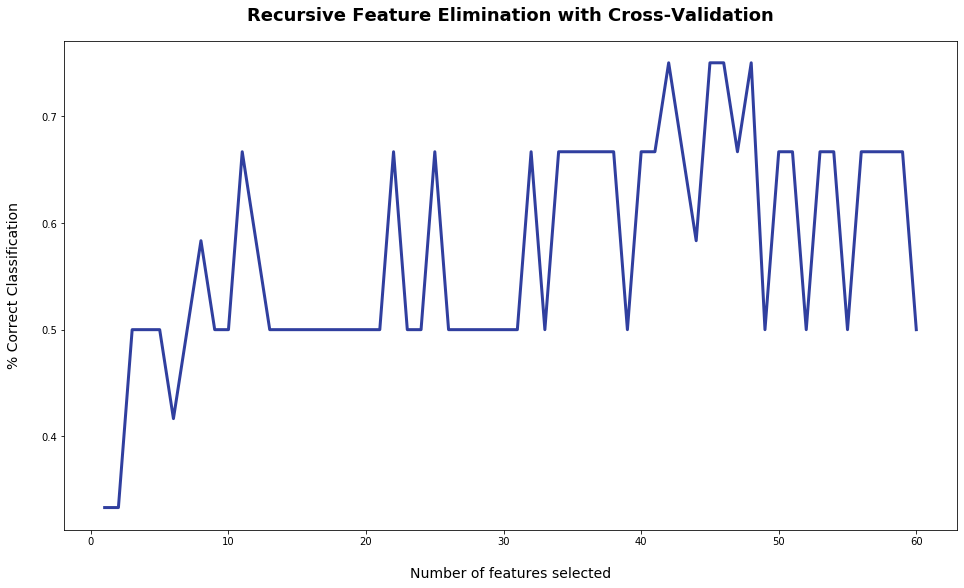

In [178]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [179]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 0 13 14 21 25 27 28 30 33 39 45 47 53 54 56 57 58 59]


In [180]:
len(train.columns)

42

##### Descriptors' relevance

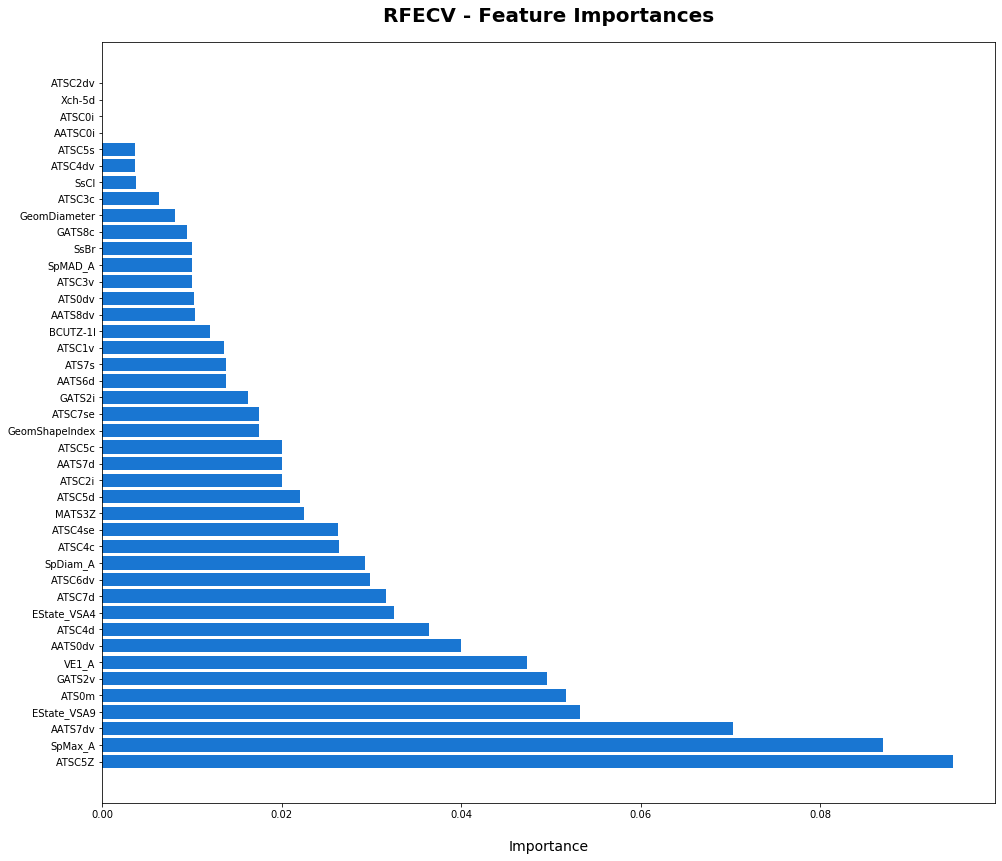

In [181]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



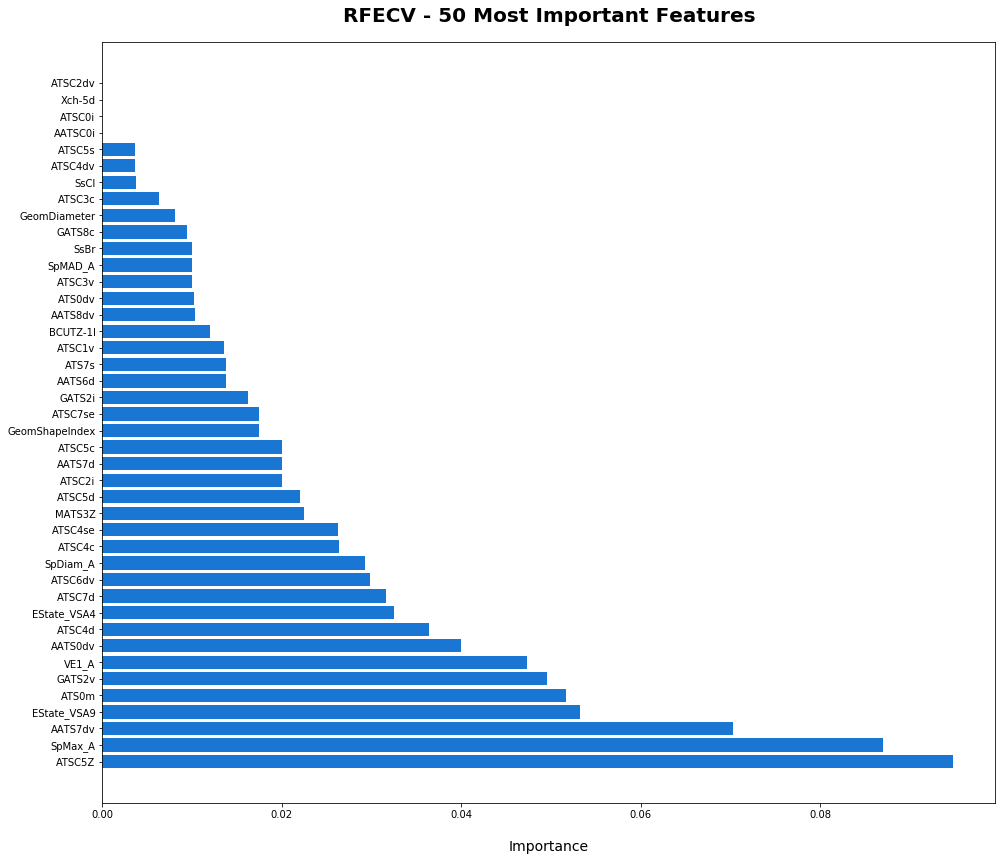

In [183]:
plt.figure(figsize=(16, 14))
plt.barh(y=dset.iloc[0:50,0], width=dset.iloc[0:50,1], color='#1976D2')
plt.title('RFECV - 50 Most Important Features', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [184]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [185]:
clf.fit(train, ic50_train_enc_all_ligand)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [186]:
ypred = clf.predict(test)

In [187]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

Accuracy: 0.6


In [188]:
clf.fit(train_sc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))


Accuracy: 0.8 - standard
Accuracy: 0.8 - MinMax
Accuracy: 0.6 - MaxAbs
Accuracy: 0.8 - Robust
Accuracy: 0.8 - Gaussian
Accuracy: 0.8 - Uniform
Accuracy: 0.2 - Normalized


#### Grid search cross-validation and SVM regressor

In [189]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [190]:
clf.fit(train, ic50_train_all_ligand)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [191]:
ypred=clf.predict(test)

In [192]:
metrics.r2_score(ic50_test_all_ligand, ypred)

-0.30635616518060216

In [193]:
clf.fit(train_sc, ic50_train_all_ligand)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_all_ligand)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_all_ligand)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_all_ligand)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_all_ligand)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_all_ligand)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

R²: -0.24941039804921306 - standard
R²: -0.2499105610895258 - MinMax
R²: -0.2498458591674393 - MaxAbs
R²: -0.24768344960323918 - Robust
R²: -0.25646688759831693 - Gaussian
R²: -0.24980916152535348 - Uniform
R²: -0.24988679950330184 - Normalized


### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [194]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [195]:
mlp.fit(train,ic50_train_enc_all_ligand)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [196]:
predictions = mlp.predict(test)

In [197]:
print(confusion_matrix(ic50_test_enc_all_ligand,predictions))
print(classification_report(ic50_test_enc_all_ligand,predictions))

[[0 1]
 [0 4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [198]:
mlp.fit(train_sc,ic50_train_enc)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_mmsc,ic50_train_enc)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_masc,ic50_train_enc)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_rsc,ic50_train_enc)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_gsc,ic50_train_enc)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_usc,ic50_train_enc)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_nsc,ic50_train_enc)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc,predictions))

NameError: name 'ic50_train_enc' is not defined

### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [199]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc_all_ligand)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc_all_ligand)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc_all_ligand)))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (test): 0.600

Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (test): 0.400

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (test): 0.400

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (test): 0.800

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (test): 1.000

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (test): 0.600

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (test): 1.000



In [200]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc_all_ligand)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc_all_ligand, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc_all_ligand, predictions))

Confusion Matrix:
[[1 0]
 [0 4]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



#### XGBoost Classifier

In [201]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [202]:
xgb_clf = XGBClassifier()

In [203]:
xgb_clf.fit(train_mmsc, ic50_train_enc_all_ligand)
xgb_clf

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [204]:
y_pred = xgb_clf.predict(test_mmsc)
predictions = [round(value) for value in y_pred]

In [205]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_test_enc_all_ligand, predictions)
print("Accuracy: {}%".format(accuracy * 100.0))

Accuracy: 80.0%


##  Isatin hplc

A congeneric series of the ligands 1e, 2{b..f} and 5{a..f}. Sample size = 9.

1. Data ensembling
2. Non-applying descriptors
    - **Correlation drop (>0.8)**
3. Train/test split - 60/40
    - **IC50 0/1 encoding (30)**
4. Feature selection
    - Pearson correlation
    - LASSO (l2)
    - RFE-CV - RF
    - RFE - SVC
    - Light gradient boosting
5. ML model
    - SVC
    - SVR
    - Neural net
    - Gradient boosing classifier
    - XGBoost classifier
    

In [497]:
descriptor_df = pd.read_excel('isatin_hplc_final_descriptors.xlsx', None)
all_ligand_descriptors = []
for key in descriptor_df.keys():
    all_ligand_descriptors.append(descriptor_df[key])
descriptors_concatenated = pd.concat(all_ligand_descriptors,axis=0,ignore_index=True)

In [498]:
descriptors_concatenated

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,5f,19.953468,15.342413,0,0,33.056466,2.516131,4.891375,33.056466,1.322259,...,10.285240,74.818540,330.100442,8.464114,1512,43,138,167,7.861111,5.361111
1,5a,11.618017,10.686635,0,0,18.884964,2.492710,4.817218,18.884964,1.258998,...,9.756321,62.128718,204.053492,8.871891,338,25,80,97,6.527778,3.250000
2,2d,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,...,9.927351,67.207515,362.975627,12.516401,680,30,102,122,6.027778,4.138889
3,5b,12.922841,11.724485,0,0,21.427190,2.505064,4.835619,21.427190,1.260423,...,9.824282,64.552556,232.084792,8.002924,492,28,88,106,7.027778,3.833333
4,2c,12.146784,11.003529,0,0,20.376059,2.497377,4.795427,20.376059,1.273504,...,9.724062,63.137928,328.991277,11.749688,420,25,82,98,6.166667,3.638889
5,2f,18.470305,14.303455,0,0,30.640860,2.509046,4.879749,30.640860,1.332211,...,10.213652,72.450100,412.991277,11.799751,1182,39,128,155,6.750000,4.916667
6,2b,11.439677,10.532996,0,0,19.014127,2.496732,4.793946,19.014127,1.267608,...,9.708263,61.959882,314.975627,12.599025,338,24,78,94,5.916667,3.388889
7,5d,16.458374,13.645776,0,0,27.366641,2.512686,4.852690,27.366641,1.303173,...,10.021582,69.675239,280.084792,8.487418,914,34,112,134,7.138889,4.583333
8,1e,9.399237,8.671298,0,0,15.331644,2.437327,4.711734,15.331644,1.277637,...,9.450695,57.579152,272.928676,17.058042,178,17,64,76,4.555556,2.583333


In [499]:
all_ligands = descriptors_concatenated

In [500]:
all_ligands

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,5f,19.953468,15.342413,0,0,33.056466,2.516131,4.891375,33.056466,1.322259,...,10.285240,74.818540,330.100442,8.464114,1512,43,138,167,7.861111,5.361111
1,5a,11.618017,10.686635,0,0,18.884964,2.492710,4.817218,18.884964,1.258998,...,9.756321,62.128718,204.053492,8.871891,338,25,80,97,6.527778,3.250000
2,2d,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,...,9.927351,67.207515,362.975627,12.516401,680,30,102,122,6.027778,4.138889
3,5b,12.922841,11.724485,0,0,21.427190,2.505064,4.835619,21.427190,1.260423,...,9.824282,64.552556,232.084792,8.002924,492,28,88,106,7.027778,3.833333
4,2c,12.146784,11.003529,0,0,20.376059,2.497377,4.795427,20.376059,1.273504,...,9.724062,63.137928,328.991277,11.749688,420,25,82,98,6.166667,3.638889
5,2f,18.470305,14.303455,0,0,30.640860,2.509046,4.879749,30.640860,1.332211,...,10.213652,72.450100,412.991277,11.799751,1182,39,128,155,6.750000,4.916667
6,2b,11.439677,10.532996,0,0,19.014127,2.496732,4.793946,19.014127,1.267608,...,9.708263,61.959882,314.975627,12.599025,338,24,78,94,5.916667,3.388889
7,5d,16.458374,13.645776,0,0,27.366641,2.512686,4.852690,27.366641,1.303173,...,10.021582,69.675239,280.084792,8.487418,914,34,112,134,7.138889,4.583333
8,1e,9.399237,8.671298,0,0,15.331644,2.437327,4.711734,15.331644,1.277637,...,9.450695,57.579152,272.928676,17.058042,178,17,64,76,4.555556,2.583333


### Non-applying descriptors

In [501]:
non_applying_descriptors = []
num_descriptors = len(all_ligands.columns)

for i in range(1, num_descriptors):
    if (str(all_ligands.dtypes[i]) != 'float64') and (str(all_ligands.dtypes[i]) != 'int64') and (str(all_ligands.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(all_ligands.columns[i])
        

In [502]:
for descriptor in non_applying_descriptors:
    all_ligands.drop(columns=[descriptor], inplace=True)

In [503]:
all_ligands.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,5f,19.953468,15.342413,0,0,33.056466,2.516131,4.891375,33.056466,1.322259,...,10.285240,74.818540,330.100442,8.464114,1512,43,138,167,7.861111,5.361111
1,5a,11.618017,10.686635,0,0,18.884964,2.492710,4.817218,18.884964,1.258998,...,9.756321,62.128718,204.053492,8.871891,338,25,80,97,6.527778,3.250000
2,2d,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,...,9.927351,67.207515,362.975627,12.516401,680,30,102,122,6.027778,4.138889
3,5b,12.922841,11.724485,0,0,21.427190,2.505064,4.835619,21.427190,1.260423,...,9.824282,64.552556,232.084792,8.002924,492,28,88,106,7.027778,3.833333
4,2c,12.146784,11.003529,0,0,20.376059,2.497377,4.795427,20.376059,1.273504,...,9.724062,63.137928,328.991277,11.749688,420,25,82,98,6.166667,3.638889
5,2f,18.470305,14.303455,0,0,30.640860,2.509046,4.879749,30.640860,1.332211,...,10.213652,72.450100,412.991277,11.799751,1182,39,128,155,6.750000,4.916667
6,2b,11.439677,10.532996,0,0,19.014127,2.496732,4.793946,19.014127,1.267608,...,9.708263,61.959882,314.975627,12.599025,338,24,78,94,5.916667,3.388889
7,5d,16.458374,13.645776,0,0,27.366641,2.512686,4.852690,27.366641,1.303173,...,10.021582,69.675239,280.084792,8.487418,914,34,112,134,7.138889,4.583333
8,1e,9.399237,8.671298,0,0,15.331644,2.437327,4.711734,15.331644,1.277637,...,9.450695,57.579152,272.928676,17.058042,178,17,64,76,4.555556,2.583333


In [504]:
all_ligands.sort_values(by=['Ligand'], inplace=True)
all_ligands.reset_index(drop=True, inplace=True)
all_ligands.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,1e,9.399237,8.671298,0,0,15.331644,2.437327,4.711734,15.331644,1.277637,...,9.450695,57.579152,272.928676,17.058042,178,17,64,76,4.555556,2.583333
1,2b,11.439677,10.532996,0,0,19.014127,2.496732,4.793946,19.014127,1.267608,...,9.708263,61.959882,314.975627,12.599025,338,24,78,94,5.916667,3.388889
2,2c,12.146784,11.003529,0,0,20.376059,2.497377,4.795427,20.376059,1.273504,...,9.724062,63.137928,328.991277,11.749688,420,25,82,98,6.166667,3.638889
3,2d,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,...,9.927351,67.207515,362.975627,12.516401,680,30,102,122,6.027778,4.138889
4,2f,18.470305,14.303455,0,0,30.640860,2.509046,4.879749,30.640860,1.332211,...,10.213652,72.450100,412.991277,11.799751,1182,39,128,155,6.750000,4.916667
5,5a,11.618017,10.686635,0,0,18.884964,2.492710,4.817218,18.884964,1.258998,...,9.756321,62.128718,204.053492,8.871891,338,25,80,97,6.527778,3.250000
6,5b,12.922841,11.724485,0,0,21.427190,2.505064,4.835619,21.427190,1.260423,...,9.824282,64.552556,232.084792,8.002924,492,28,88,106,7.027778,3.833333
7,5d,16.458374,13.645776,0,0,27.366641,2.512686,4.852690,27.366641,1.303173,...,10.021582,69.675239,280.084792,8.487418,914,34,112,134,7.138889,4.583333
8,5f,19.953468,15.342413,0,0,33.056466,2.516131,4.891375,33.056466,1.322259,...,10.285240,74.818540,330.100442,8.464114,1512,43,138,167,7.861111,5.361111


In [505]:
all_ligands.drop(all_ligands.index[0], inplace=True)

In [506]:
all_ligands

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
1,2b,11.439677,10.532996,0,0,19.014127,2.496732,4.793946,19.014127,1.267608,...,9.708263,61.959882,314.975627,12.599025,338,24,78,94,5.916667,3.388889
2,2c,12.146784,11.003529,0,0,20.376059,2.497377,4.795427,20.376059,1.273504,...,9.724062,63.137928,328.991277,11.749688,420,25,82,98,6.166667,3.638889
3,2d,14.975211,12.541993,0,0,24.948691,2.505089,4.818967,24.948691,1.313089,...,9.927351,67.207515,362.975627,12.516401,680,30,102,122,6.027778,4.138889
4,2f,18.470305,14.303455,0,0,30.640860,2.509046,4.879749,30.640860,1.332211,...,10.213652,72.450100,412.991277,11.799751,1182,39,128,155,6.750000,4.916667
5,5a,11.618017,10.686635,0,0,18.884964,2.492710,4.817218,18.884964,1.258998,...,9.756321,62.128718,204.053492,8.871891,338,25,80,97,6.527778,3.250000
6,5b,12.922841,11.724485,0,0,21.427190,2.505064,4.835619,21.427190,1.260423,...,9.824282,64.552556,232.084792,8.002924,492,28,88,106,7.027778,3.833333
7,5d,16.458374,13.645776,0,0,27.366641,2.512686,4.852690,27.366641,1.303173,...,10.021582,69.675239,280.084792,8.487418,914,34,112,134,7.138889,4.583333
8,5f,19.953468,15.342413,0,0,33.056466,2.516131,4.891375,33.056466,1.322259,...,10.285240,74.818540,330.100442,8.464114,1512,43,138,167,7.861111,5.361111


In [507]:
pic50_all_ligands = pd.read_csv('/home/vant/data/PeleAI_data/covid/drug_learning/drug_learning/datasets/SAR1/isatin_hplc/ic50.csv')
pic50_all_ligands.index

RangeIndex(start=0, stop=10, step=1)

In [508]:
pic50_all_ligands.head(14)

,path,IC50
0,1e,1000.00
1,2b,1000.00
2,2c,66.00
3,2d,50.00
4,2f,1.10
5,5a,71.00
6,5b,25.00
7,5c,19.00
8,5d,12.50
9,5f,0.37


In [509]:
pic50_all_ligands.columns = ['Ligand', 'IC50']

In [510]:
pic50_all_ligands.head(14)

,Ligand,IC50
0,1e,1000.00
1,2b,1000.00
2,2c,66.00
3,2d,50.00
4,2f,1.10
5,5a,71.00
6,5b,25.00
7,5c,19.00
8,5d,12.50
9,5f,0.37


In [511]:
correlated_features = set()
correlation_matrix = all_ligands.drop('Ligand', axis=1).corr()

In [512]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'ATS3s', 'piPC4', 'C3SP2', 'TopoPSA(NO)', 'DPSA4', 'VR1_Dzm', 'AETA_beta', 'MATS1p', 'ATSC0p', 'ETA_eta_FL', 'ATS0s', 'ATS1dv', 'ATS6s', 'AATSC1Z', 'AATSC6are', 'ATSC4v', 'GATS3Z', 'AATS4v', 'MATS5v', 'LogEE_DzZ', 'Sv', 'ATSC0dv', 'ETA_dPsi_A', 'MPC4', 'RPSA', 'RNCS', 'VE2_D', 'EState_VSA2', 'Xpc-5dv', 'ATSC8m', 'GATS6d', 'ATS2m', 'BCUTm-1l', 'Radius', 'SRW06', 'AATSC3i', 'ATSC8are', 'WPSA1', 'AATSC6s', 'AATS4Z', 'ATSC2pe', 'GATS3are', 'BertzCT', 'MATS2s', 'VR3_Dzi', 'GATS1m', 'ATSC2are', 'SpMAD_Dzse', 'MIC1', 'nBondsKS', 'SpDiam_Dzse', 'TIC2', 'ATS8p', 'TSRW10', 'AATSC2pe', 'ETA_alpha', 'AATS4are', 'AATS2se', 'BCUTc-1l', 'SRW02', 'ATS1s', 'ATSC1s', 'ATSC0m', 'ATSC5c', 'PEOE_VSA6', 'NaaaC', 'ETA_shape_y', 'BIC0', 'MATS5dv', 'AATSC2Z', 'Xp-3dv', 'SpAD_D', 'Mor01v', 'LogEE_Dzv', 'piPC10', 'MATS2Z', 'nFaRing', 'SM1_Dzp', 'ATSC3Z', 'VE1_Dzi', 'Kier2', 'CIC2', 'ATSC8p', 'ATSC4pe', 'GATS2p', 'GATS6pe', 'piPC9', 'AATSC6p', 'WPol', 'ZMIC4', 'nRot', 'CIC3', 'RNCG', 'GGI1', 'ATS6Z', 'JGI1', 'AT

In [514]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(all_ligands.columns)))
all_ligands = all_ligands.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(all_ligands.columns)))

Correlated descriptors computed: 1070
Number of descriptors before discard: 1396
Number of descriptors after discard: 326


In [515]:
all_ligands = all_ligands.merge(pic50_all_ligands, how='left')

In [516]:
train, test = train_test_split(all_ligands, test_size=0.3, random_state=2)

In [517]:
test

,Ligand,ABC,nAcid,nBase,nSpiro,nBridgehead,nHetero,nB,nS,nP,...,n7FAHRing,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12FAHRing,nG12FAHRing,SRW03,SRW05,IC50
4,5a,11.618017,0,0,0,0,5,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,71.0
1,2c,12.146784,0,0,0,0,4,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,66.0
6,5d,16.458374,0,0,0,0,5,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,12.5


In [518]:
train

,Ligand,ABC,nAcid,nBase,nSpiro,nBridgehead,nHetero,nB,nS,nP,...,n7FAHRing,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12FAHRing,nG12FAHRing,SRW03,SRW05,IC50
2,2d,14.975211,0,0,0,0,4,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,50.00
3,2f,18.470305,0,0,0,0,4,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,1.10
7,5f,19.953468,0,0,0,0,5,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,0.37
5,5b,12.922841,0,0,0,0,5,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,25.00
0,2b,11.439677,0,0,0,0,4,0,0,0,...,0,0,1,0,0,0,0,0,2.397895,1000.00


In [519]:
ic50_train_all_ligand = train['IC50']
ic50_test_all_ligand = test['IC50']

In [520]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)

In [521]:
ic50_train_enc_all_ligand = [1 if ic50 > 30 else 0 for ic50 in ic50_train_all_ligand.values]
ic50_test_enc_all_ligand = [1 if ic50 > 30 else 0 for ic50 in ic50_test_all_ligand.values]

In [522]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)

##### Standard

In [523]:
scaler = StandardScaler()

In [524]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [525]:
scaler = MinMaxScaler()

In [526]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [527]:
scaler = MaxAbsScaler()

In [528]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [529]:
scaler = RobustScaler()

In [468]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [469]:
scaler = PowerTransformer(method='yeo-johnson')

In [470]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [471]:
scaler = QuantileTransformer(output_distribution='normal')

In [472]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [473]:
scaler = QuantileTransformer(output_distribution='uniform')

In [474]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [475]:
scaler = Normalizer()

In [476]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Pearson correlation

In [400]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [401]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc_all_ligand, len(train.columns))
print(str(len(cor_feature)), 'selected features')

325 selected features


#### LASSO

In [402]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

5 selected features


In [133]:
#train_lasso = train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1)
#test_lasso = test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1)

#### Light Gradient Boosting Classifier

In [329]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [330]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=325, norm_order=1, prefit=False,

In [331]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

In [332]:
print(str(len(embeded_lgb_feature)), 'selected features')

325 selected features


### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)

- Error report:

        * n_splits=2 cannot be greater than the number of members in each class.
        * The classifier does not expose "coef_" or "feature_importances_" attributes
        
Dependence on train/test split

In [403]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 162 - 
Optimal number of features: 162 - Standard
Optimal number of features: 162 - MinMax
Optimal number of features: 162 - MaxAbs
Optimal number of features: 162 - Robust
Optimal number of features: 162 - Yeo-Johnson
Optimal number of features: 162 - Gaussian
Optimal number of features: 162 - uniform
Optimal number of features: 162 - normalized


In [105]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

##### Proceeding to RFE-CV with Random Forest Classifier


In [477]:
rfc = RandomForestClassifier(random_state=101)

In [478]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(3), scoring='accuracy')

In [479]:
rfecv.fit(train, ic50_train_enc_all_ligand)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [480]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 7


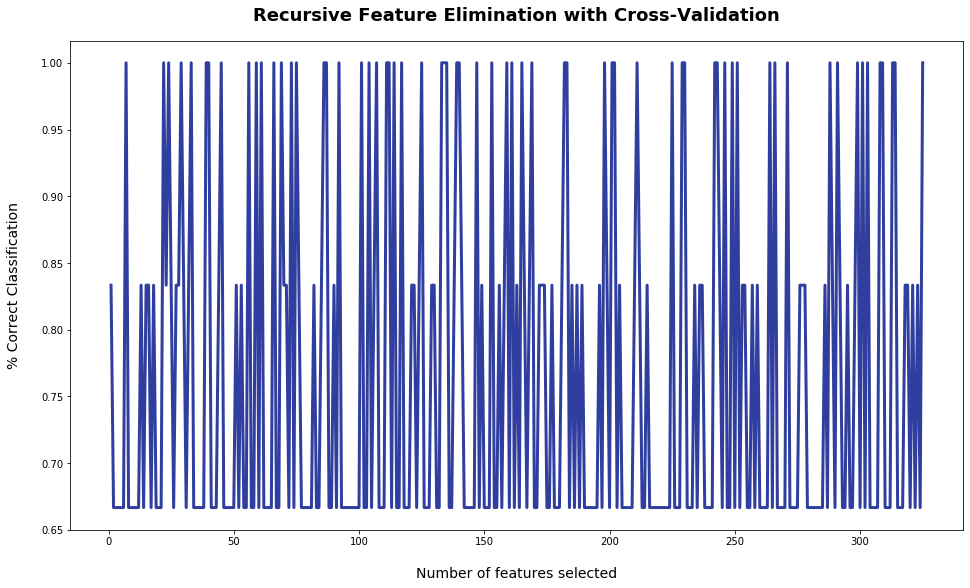

In [481]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [482]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[  1   2   3   4   6   7   8   9  10  11  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 171 172 173 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 25

In [483]:
len(train.columns)

7

##### Descriptors' relevance

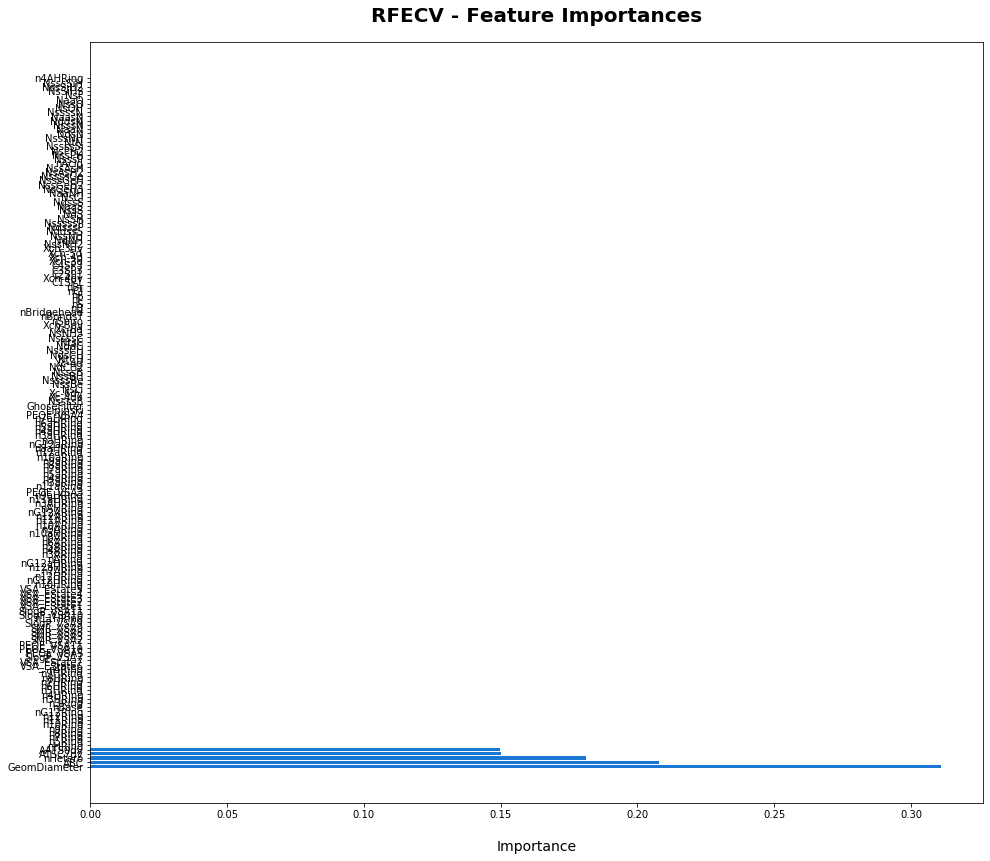

In [270]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



In [271]:
dset

,attr,importance
81,GeomDiameter,0.310819
0,ABC,0.207749
5,nHetero,0.181287
13,ATSC7dv,0.150292
12,AATS0dv,0.149854
...,...,...
58,NsF,0.000000
59,NsSiH3,0.000000
60,NssSiH2,0.000000
61,NsssSiH,0.000000


### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [488]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [489]:
clf.fit(train, ic50_train_enc_all_ligand)

ValueError: n_splits=5 cannot be greater than the number of members in each class.

In [ ]:
ypred = clf.predict(test)

In [187]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

ValueError: Found input variables with inconsistent numbers of samples: [3, 16]

In [188]:
clf.fit(train_sc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))


Accuracy: 0.8 - standard
Accuracy: 0.8 - MinMax
Accuracy: 0.6 - MaxAbs
Accuracy: 0.8 - Robust
Accuracy: 0.8 - Gaussian
Accuracy: 0.8 - Uniform
Accuracy: 0.2 - Normalized


#### Grid search cross-validation and SVM regressor

In [189]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [190]:
clf.fit(train, ic50_train_all_ligand)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [191]:
ypred=clf.predict(test)

In [192]:
metrics.r2_score(ic50_test_all_ligand, ypred)

-0.30635616518060216

In [193]:
clf.fit(train_sc, ic50_train_all_ligand)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_all_ligand)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_all_ligand)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_all_ligand)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_all_ligand)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_all_ligand)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

R²: -0.24941039804921306 - standard
R²: -0.2499105610895258 - MinMax
R²: -0.2498458591674393 - MaxAbs
R²: -0.24768344960323918 - Robust
R²: -0.25646688759831693 - Gaussian
R²: -0.24980916152535348 - Uniform
R²: -0.24988679950330184 - Normalized


### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [194]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [195]:
mlp.fit(train,ic50_train_enc_all_ligand)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [196]:
predictions = mlp.predict(test)

In [197]:
print(confusion_matrix(ic50_test_enc_all_ligand,predictions))
print(classification_report(ic50_test_enc_all_ligand,predictions))

[[0 1]
 [0 4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      1.00      0.89         4

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



In [198]:
mlp.fit(train_sc,ic50_train_enc)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_mmsc,ic50_train_enc)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_masc,ic50_train_enc)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_rsc,ic50_train_enc)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_gsc,ic50_train_enc)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_usc,ic50_train_enc)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc,predictions))

mlp.fit(train_nsc,ic50_train_enc)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc,predictions))

NameError: name 'ic50_train_enc' is not defined

### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [490]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc_all_ligand)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc_all_ligand)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc_all_ligand)))
    print()

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (test): 0.667

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (test): 0.667



In [491]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc_all_ligand)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc_all_ligand, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc_all_ligand, predictions))

Confusion Matrix:
[[1 0]
 [1 1]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



#### XGBoost Classifier

In [492]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [493]:
xgb_clf = XGBClassifier()

In [494]:
xgb_clf.fit(train_mmsc, ic50_train_enc_all_ligand)
xgb_clf

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [495]:
y_pred = xgb_clf.predict(test_mmsc)
predictions = [round(value) for value in y_pred]

In [496]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_test_enc_all_ligand, predictions)
print("Accuracy: {}%".format(accuracy * 100.0))

Accuracy: 33.33333333333333%


## Triazole

A congeneric series of the ligands ... many. Sample size = 53.

_Note: not all the ligands had a IC50 value assigned and not all the assigned IC50 had a ligand._

1. Data ensembling
2. Non-applying descriptors
    - **Correlation drop (>0.8)**
3. Train/test/validation split - 60/20/20
    - **IC50 0/1 encoding (7)**
4. Feature selection
    - Pearson correlation
    - **LASSO (l2)**
    - RFE-CV - RF
    - **RFE - SVC**
    - Light gradient boosting
5. ML model
    - **SVC**
    - **SVR**
    - **Neural net**
    - Gradient boosing classifier
    - XGBoost classifier
    

In [230]:
descriptor_df = pd.read_excel("trizaole_final_descriptors.xlsx", None)
all_ligand_descriptors = []
for key in descriptor_df.keys():
    all_ligand_descriptors.append(descriptor_df[key])
descriptors_concatenated = pd.concat(all_ligand_descriptors,axis=0,ignore_index=True)

In [231]:
descriptors_concatenated

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,16g,26.886637,20.401082,0,0,45.528715,2.425366,4.789794,45.528715,1.339080,...,10.343580,85.812297,473.188546,7.757189,3783,50,180,211,8.611111,7.472222
1,16e,24.765316,19.406176,0,0,41.531712,2.426187,4.786139,41.531712,1.339733,...,10.310651,87.010843,431.141596,8.291185,2867,45,168,199,7.861111,6.722222
2,9b,28.984455,24.108281,0,1,45.872267,2.483323,4.921773,45.872267,1.239791,...,10.522746,89.608351,518.222037,7.510464,4083,57,196,229,13.395833,7.930556
3,163,24.208040,19.283234,0,0,40.527433,2.426456,4.786292,40.527433,1.307337,...,10.230234,82.444253,416.196074,7.567201,2838,45,162,189,9.361111,6.861111
4,13702,34.342893,26.316373,0,0,57.146720,2.469089,4.924750,57.146720,1.298789,...,10.651762,95.497273,612.205195,8.273043,6721,71,230,270,14.166667,9.666667
5,150,24.909672,21.371824,0,0,39.138863,2.469152,4.930012,39.138863,1.223089,...,10.391730,81.218376,433.247775,6.876949,2683,49,168,194,12.513889,6.791667
6,17d,24.655927,18.923307,0,0,42.075702,2.427327,4.803052,42.075702,1.357281,...,10.289804,82.459481,425.131031,8.502621,2816,46,166,196,7.250000,6.805556
7,9a,28.208399,23.373741,0,1,44.983530,2.467826,4.904391,44.983530,1.249543,...,10.467351,88.212149,504.206387,7.639491,3838,54,190,221,12.534722,7.736111
8,17c,26.029700,20.141381,0,0,44.514727,2.430515,4.825134,44.514727,1.348931,...,10.381428,84.810767,455.141596,8.428548,3332,51,176,209,8.361111,7.333333
9,13l,31.146216,25.153452,0,0,49.947456,2.467988,4.904892,49.947456,1.248686,...,10.520482,92.591597,562.236225,7.597787,5403,59,208,240,14.145833,8.652778


In [232]:
all_ligands = descriptors_concatenated

In [233]:
all_ligands

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,16g,26.886637,20.401082,0,0,45.528715,2.425366,4.789794,45.528715,1.339080,...,10.343580,85.812297,473.188546,7.757189,3783,50,180,211,8.611111,7.472222
1,16e,24.765316,19.406176,0,0,41.531712,2.426187,4.786139,41.531712,1.339733,...,10.310651,87.010843,431.141596,8.291185,2867,45,168,199,7.861111,6.722222
2,9b,28.984455,24.108281,0,1,45.872267,2.483323,4.921773,45.872267,1.239791,...,10.522746,89.608351,518.222037,7.510464,4083,57,196,229,13.395833,7.930556
3,163,24.208040,19.283234,0,0,40.527433,2.426456,4.786292,40.527433,1.307337,...,10.230234,82.444253,416.196074,7.567201,2838,45,162,189,9.361111,6.861111
4,13702,34.342893,26.316373,0,0,57.146720,2.469089,4.924750,57.146720,1.298789,...,10.651762,95.497273,612.205195,8.273043,6721,71,230,270,14.166667,9.666667
5,150,24.909672,21.371824,0,0,39.138863,2.469152,4.930012,39.138863,1.223089,...,10.391730,81.218376,433.247775,6.876949,2683,49,168,194,12.513889,6.791667
6,17d,24.655927,18.923307,0,0,42.075702,2.427327,4.803052,42.075702,1.357281,...,10.289804,82.459481,425.131031,8.502621,2816,46,166,196,7.250000,6.805556
7,9a,28.208399,23.373741,0,1,44.983530,2.467826,4.904391,44.983530,1.249543,...,10.467351,88.212149,504.206387,7.639491,3838,54,190,221,12.534722,7.736111
8,17c,26.029700,20.141381,0,0,44.514727,2.430515,4.825134,44.514727,1.348931,...,10.381428,84.810767,455.141596,8.428548,3332,51,176,209,8.361111,7.333333
9,13l,31.146216,25.153452,0,0,49.947456,2.467988,4.904892,49.947456,1.248686,...,10.520482,92.591597,562.236225,7.597787,5403,59,208,240,14.145833,8.652778


### Non-applying descriptors

In [234]:
non_applying_descriptors = []
num_descriptors = len(all_ligands.columns)

for i in range(1, num_descriptors):
    if (str(all_ligands.dtypes[i]) != 'float64') and (str(all_ligands.dtypes[i]) != 'int64') and (str(all_ligands.dtypes[i]) != 'bool'):
        non_applying_descriptors.append(all_ligands.columns[i])
        

In [235]:
for descriptor in non_applying_descriptors:
    all_ligands.drop(columns=[descriptor], inplace=True)

In [236]:
all_ligands.head(64)
all_ligands["Ligand"] = all_ligands["Ligand"].astype(str)

In [237]:
all_ligands.sort_values(by=['Ligand'], inplace=True)
all_ligands.reset_index(drop=True, inplace=True)
all_ligands.head(64)

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10a,24.753745,21.443642,0,0,39.137741,2.453293,4.886434,39.137741,1.223054,...,10.243133,82.858260,454.178710,7.830667,2802,44,164,187,11.812500,6.930556
1,10b,27.997318,23.824111,0,0,42.936193,2.458537,4.892090,42.936193,1.192672,...,10.443105,87.931054,526.218236,7.517403,3923,52,188,215,14.736111,7.597222
2,13692,31.824454,24.796040,0,0,53.332791,2.467484,4.902152,53.332791,1.333320,...,10.600154,97.336558,556.225660,7.725356,5231,62,216,257,10.444444,8.722222
3,13701,29.703133,23.658094,0,0,49.500907,2.471282,4.901208,49.500907,1.337862,...,10.574772,96.006748,514.178710,8.161567,4246,57,204,245,9.694444,7.972222
4,13702,34.342893,26.316373,0,0,57.146720,2.469089,4.924750,57.146720,1.298789,...,10.651762,95.497273,612.205195,8.273043,6721,71,230,270,14.166667,9.666667
5,13a,28.208399,23.373741,0,0,44.983530,2.467826,4.904391,44.983530,1.249543,...,10.467351,88.212149,504.194360,7.878037,3838,54,190,221,12.534722,7.736111
6,13b,29.173482,24.093485,0,0,45.550944,2.468653,4.906906,45.550944,1.231107,...,10.529720,89.462705,540.161345,8.310175,4148,55,198,229,13.486111,7.777778
7,13c,28.806116,23.814578,0,0,46.698915,2.467937,4.904729,46.698915,1.262133,...,10.482654,89.308040,518.210010,7.734478,4182,56,194,226,12.784722,8.069444
8,13d,29.691562,24.474724,0,0,47.467824,2.468138,4.905356,47.467824,1.249153,...,10.516861,90.469141,532.225660,7.603224,4528,58,200,233,13.645833,8.180556
9,13e,30.635476,25.225718,0,0,48.068200,2.468614,4.906919,48.068200,1.232518,...,10.590994,91.735461,546.241310,7.482758,4876,60,208,242,14.597222,8.236111


In [238]:
all_ligands

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10a,24.753745,21.443642,0,0,39.137741,2.453293,4.886434,39.137741,1.223054,...,10.243133,82.858260,454.178710,7.830667,2802,44,164,187,11.812500,6.930556
1,10b,27.997318,23.824111,0,0,42.936193,2.458537,4.892090,42.936193,1.192672,...,10.443105,87.931054,526.218236,7.517403,3923,52,188,215,14.736111,7.597222
2,13692,31.824454,24.796040,0,0,53.332791,2.467484,4.902152,53.332791,1.333320,...,10.600154,97.336558,556.225660,7.725356,5231,62,216,257,10.444444,8.722222
3,13701,29.703133,23.658094,0,0,49.500907,2.471282,4.901208,49.500907,1.337862,...,10.574772,96.006748,514.178710,8.161567,4246,57,204,245,9.694444,7.972222
4,13702,34.342893,26.316373,0,0,57.146720,2.469089,4.924750,57.146720,1.298789,...,10.651762,95.497273,612.205195,8.273043,6721,71,230,270,14.166667,9.666667
5,13a,28.208399,23.373741,0,0,44.983530,2.467826,4.904391,44.983530,1.249543,...,10.467351,88.212149,504.194360,7.878037,3838,54,190,221,12.534722,7.736111
6,13b,29.173482,24.093485,0,0,45.550944,2.468653,4.906906,45.550944,1.231107,...,10.529720,89.462705,540.161345,8.310175,4148,55,198,229,13.486111,7.777778
7,13c,28.806116,23.814578,0,0,46.698915,2.467937,4.904729,46.698915,1.262133,...,10.482654,89.308040,518.210010,7.734478,4182,56,194,226,12.784722,8.069444
8,13d,29.691562,24.474724,0,0,47.467824,2.468138,4.905356,47.467824,1.249153,...,10.516861,90.469141,532.225660,7.603224,4528,58,200,233,13.645833,8.180556
9,13e,30.635476,25.225718,0,0,48.068200,2.468614,4.906919,48.068200,1.232518,...,10.590994,91.735461,546.241310,7.482758,4876,60,208,242,14.597222,8.236111


In [239]:
pic50_all_ligands = pd.read_csv('/home/vant/data/PeleAI_data/covid/drug_learning/drug_learning/datasets/SAR1/triazole/ic50.csv')
pic50_all_ligands.index

RangeIndex(start=0, stop=60, step=1)

In [240]:
pic50_all_ligands.head(14)

,path,IC50
0,9c,1000.00
1,9b,1000.00
2,9a,1000.00
3,10a,1000.00
4,10b,1000.00
5,12,20.00
6,13a,7.72
7,13b,25.30
8,13c,6.90
9,13d,4.10


In [241]:
pic50_all_ligands.columns = ['Ligand', 'IC50']

In [242]:
pic50_all_ligands.head(14)

,Ligand,IC50
0,9c,1000.00
1,9b,1000.00
2,9a,1000.00
3,10a,1000.00
4,10b,1000.00
5,12,20.00
6,13a,7.72
7,13b,25.30
8,13c,6.90
9,13d,4.10


In [243]:
pic50_all_ligands["Ligand"] = pic50_all_ligands["Ligand"].astype(str)

In [244]:
pic50_all_ligands.sort_values(by=['Ligand'], inplace=True)
pic50_all_ligands.reset_index(drop=True, inplace=True)
pic50_all_ligands.head(64)

,Ligand,IC50
0,10a,1000.000
1,10b,1000.000
2,12,20.000
3,13a,7.720
4,13b,25.300
5,13c,6.900
6,13d,4.100
7,13e,22.500
8,13f,9.100
9,13g,3.800


In [245]:
all_ligands = all_ligands[all_ligands.Ligand != '13692']
all_ligands = all_ligands[all_ligands.Ligand != '13701']
all_ligands = all_ligands[all_ligands.Ligand != '13702']
all_ligands = all_ligands[all_ligands.Ligand != '6']


pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '9739']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '9740']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '9741']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '148']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '152']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '153']
pic50_all_ligands = pic50_all_ligands[pic50_all_ligands.Ligand != '12']


In [246]:
all_ligands

,Ligand,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,10a,24.753745,21.443642,0,0,39.137741,2.453293,4.886434,39.137741,1.223054,...,10.243133,82.858260,454.178710,7.830667,2802,44,164,187,11.812500,6.930556
1,10b,27.997318,23.824111,0,0,42.936193,2.458537,4.892090,42.936193,1.192672,...,10.443105,87.931054,526.218236,7.517403,3923,52,188,215,14.736111,7.597222
5,13a,28.208399,23.373741,0,0,44.983530,2.467826,4.904391,44.983530,1.249543,...,10.467351,88.212149,504.194360,7.878037,3838,54,190,221,12.534722,7.736111
6,13b,29.173482,24.093485,0,0,45.550944,2.468653,4.906906,45.550944,1.231107,...,10.529720,89.462705,540.161345,8.310175,4148,55,198,229,13.486111,7.777778
7,13c,28.806116,23.814578,0,0,46.698915,2.467937,4.904729,46.698915,1.262133,...,10.482654,89.308040,518.210010,7.734478,4182,56,194,226,12.784722,8.069444
8,13d,29.691562,24.474724,0,0,47.467824,2.468138,4.905356,47.467824,1.249153,...,10.516861,90.469141,532.225660,7.603224,4528,58,200,233,13.645833,8.180556
9,13e,30.635476,25.225718,0,0,48.068200,2.468614,4.906919,48.068200,1.232518,...,10.590994,91.735461,546.241310,7.482758,4876,60,208,242,14.597222,8.236111
10,13f,30.179889,24.473963,0,0,48.662814,2.468999,4.905933,48.662814,1.280600,...,10.578343,95.147703,530.210010,7.797206,4527,58,206,243,12.145833,8.097222
11,13g,30.886996,25.093882,0,0,48.797715,2.468596,4.906928,48.797715,1.251223,...,10.627091,91.890583,544.225660,7.665150,4910,59,210,247,12.395833,8.347222
12,13h,32.301210,25.438726,0,0,52.659883,2.468386,4.906196,52.659883,1.284387,...,10.603635,93.902837,572.256960,7.431909,5720,63,218,255,12.895833,8.847222


In [247]:
len(pic50_all_ligands.index)

53

In [248]:
correlated_features = set()
correlation_matrix = all_ligands.drop('Ligand', axis=1).corr()

In [249]:
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
print(correlated_features)

{'AATSC5are', 'AATS5s', 'ATSC8p', 'AATSC0c', 'Xc-5d', 'WPSA3', 'AMID', 'GATS3v', 'AATSC4are', 'Xp-3d', 'BCUTm-1h', 'piPC6', 'GATS8p', 'n5aRing', 'GATS5Z', 'VE2_DzZ', 'AATS2d', 'AATS0s', 'ETA_beta', 'AATSC5s', 'MPC8', 'MATS6d', 'ATSC0Z', 'Mor01v', 'EState_VSA10', 'ATSC6i', 'MATS1p', 'VR1_Dzare', 'Mare', 'VE1_A', 'ATSC4are', 'Xch-4dv', 'AATS5Z', 'SRW05', 'IC0', 'MATS4dv', 'piPC7', 'SM1_Dzse', 'SdO', 'ATSC0m', 'SM1_Dzare', 'MATS8s', 'ATSC5s', 'SpMAD_Dzp', 'AATS3Z', 'VR2_Dzm', 'SaaCH', 'Sv', 'MATS6s', 'ATSC1are', 'AATSC0v', 'MDEC-22', 'AETA_eta_BR', 'PEOE_VSA7', 'AATS6m', 'WNSA3', 'AATSC1c', 'ATS1i', 'SpMax_Dzare', 'MAXaasC', 'GATS6are', 'ETA_dBeta', 'AATS4dv', 'VE2_Dzare', 'AATSC6v', 'MATS5are', 'SaaaC', 'nFaRing', 'GRAV', 'SpMax_Dzm', 'SMR_VSA5', 'AATSC3s', 'GRAVp', 'ATS8se', 'TIC3', 'PEOE_VSA8', 'EState_VSA4', 'ATSC2pe', 'MATS7se', 'MATS8m', 'GATS5pe', 'AATS8p', 'AATSC6dv', 'PPSA4', 'ATSC7d', 'AATSC4d', 'EState_VSA2', 'AATSC6Z', 'nBondsA', 'MATS2s', 'Spe', 'MATS6i', 'VR2_A', 'SlogP_VSA7

In [250]:
print("Correlated descriptors computed: {}".format(len(correlated_features)))
print("Number of descriptors before discard: {}".format(len(all_ligands.columns)))
all_ligands = all_ligands.drop(correlated_features, axis=1)
print("Number of descriptors after discard: {}".format(len(all_ligands.columns)))

Correlated descriptors computed: 1131
Number of descriptors before discard: 1494
Number of descriptors after discard: 363


In [251]:
all_ligands = all_ligands.merge(pic50_all_ligands, how='left')

In [252]:
train, test = train_test_split(all_ligands, test_size=0.3, random_state=2)

In [253]:
train, validate, test = np.split(all_ligands.sample(frac=1), [int(.6*len(all_ligands)), int(.8*len(all_ligands))])

In [254]:
validate

,Ligand,ABC,nAcid,nBase,SpMAD_A,VR1_A,nAromAtom,nSpiro,nBridgehead,nHetero,...,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12FAHRing,nG12FAHRing,RotRatio,JGI2,TopoShapeIndex,IC50
34,16c,25.220903,0,0,1.279283,374.439135,20,0,0,8,...,0,0,0,0,0,0,0.171429,0.080000,0.875000,13.300
31,167,25.472423,0,0,1.345883,342.327045,26,0,0,6,...,0,0,0,0,0,0,0.166667,0.071111,0.875000,0.051
17,150,24.909672,0,0,1.223089,254.390178,17,0,0,7,...,0,0,0,0,0,0,0.147059,0.080000,0.833333,6.000
18,151,24.909672,0,0,1.223089,254.390178,17,0,0,7,...,0,0,0,0,0,0,0.147059,0.080000,0.833333,47.000
32,16a,23.391543,0,0,1.318924,415.077331,20,0,0,8,...,0,0,0,0,0,0,0.212121,0.069136,0.875000,2.900
41,16j,21.160833,0,0,1.337739,262.912144,20,0,0,7,...,0,0,0,0,0,0,0.200000,0.070461,0.857143,2.100
40,16i,25.731643,0,0,1.297462,954.136031,20,0,0,9,...,0,0,0,0,0,0,0.222222,0.068027,0.888889,10.300
43,17a,24.655927,0,0,1.357281,342.305801,26,0,0,6,...,0,0,0,0,0,0,0.171429,0.069444,0.875000,0.051
20,155,24.909672,0,0,1.223089,254.390178,17,0,0,7,...,0,0,0,0,0,0,0.147059,0.080000,0.833333,5.500
22,158,30.479549,0,0,1.243496,531.360832,22,0,0,10,...,0,0,0,0,0,0,0.190476,0.062963,1.000000,11.000


In [255]:
test

,Ligand,ABC,nAcid,nBase,SpMAD_A,VR1_A,nAromAtom,nSpiro,nBridgehead,nHetero,...,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12FAHRing,nG12FAHRing,RotRatio,JGI2,TopoShapeIndex,IC50
0,10a,24.753745,0,0,1.223054,329.806369,16,0,0,10,...,0,0,0,0,0,0,0.205882,0.060185,1.000000,1000.00
16,149,24.909672,0,0,1.223089,254.390178,17,0,0,6,...,0,0,0,0,0,0,0.147059,0.080000,0.833333,50.00
11,13j,31.594103,0,0,1.278669,580.545157,25,0,0,11,...,0,0,0,0,0,0,0.181818,0.070547,1.000000,100.00
28,164,25.093486,0,0,1.290513,424.608364,20,0,0,8,...,0,0,0,0,0,0,0.200000,0.077098,0.875000,3.60
35,16d,24.805756,0,0,1.314784,850.190969,20,0,0,9,...,0,0,0,0,0,0,0.257143,0.066194,0.888889,3.40
44,17b,24.655927,0,0,1.357281,342.305801,26,0,0,7,...,0,0,0,0,0,0,0.171429,0.069444,0.875000,0.97
5,13d,29.691562,0,0,1.249153,462.463378,20,0,0,10,...,0,0,0,0,0,0,0.195122,0.075330,0.875000,4.10
45,17c,26.029700,0,0,1.348931,314.468311,26,0,0,8,...,0,0,0,0,0,0,0.189189,0.074074,0.875000,0.70
26,162,31.703493,0,0,1.243920,493.235140,20,0,0,10,...,0,0,0,0,0,0,0.181818,0.073477,1.000000,3.80
48,9738,26.554236,0,0,1.288489,357.214192,17,0,0,7,...,0,0,0,0,0,0,0.162162,0.072650,0.857143,2.30


In [256]:
train

,Ligand,ABC,nAcid,nBase,SpMAD_A,VR1_A,nAromAtom,nSpiro,nBridgehead,nHetero,...,n8FAHRing,n9FAHRing,n10FAHRing,n11FAHRing,n12FAHRing,nG12FAHRing,RotRatio,JGI2,TopoShapeIndex,IC50
42,16k,25.403473,0,0,1.346174,533.659903,26,0,0,7,...,0,0,0,0,0,0,0.194444,0.058957,1.000000,1.50
24,160,30.508059,0,0,1.241789,485.604018,20,0,0,10,...,0,0,0,0,0,0,0.190476,0.076503,0.875000,4.10
3,13b,29.173482,0,0,1.231107,357.265783,20,0,0,12,...,0,0,0,0,0,0,0.200000,0.067797,1.000000,25.30
6,13e,30.635476,0,0,1.232518,428.964097,20,0,0,10,...,0,0,0,0,0,0,0.166667,0.078853,0.875000,22.50
33,16b,24.276989,0,0,1.301183,427.777818,20,0,0,8,...,0,0,0,0,0,0,0.205882,0.075650,0.875000,3.60
19,153,25.726168,0,1,1.216122,265.820127,17,0,0,7,...,0,0,0,0,0,0,0.142857,0.081197,0.833333,NaN
30,166,26.288920,0,0,1.291597,397.887462,20,0,0,8,...,0,0,0,0,0,0,0.189189,0.073333,1.000000,8.10
51,9b,28.984455,0,1,1.239791,428.238896,20,0,0,9,...,0,0,0,0,0,0,0.175000,0.068966,1.000000,1000.00
46,17d,24.655927,0,0,1.357281,342.305801,26,0,0,7,...,0,0,0,0,0,0,0.171429,0.069444,0.875000,2.00
52,9c,25.529802,0,1,1.215477,328.407872,16,0,0,9,...,0,0,0,0,0,0,0.200000,0.071111,1.000000,1000.00


In [257]:
ic50_train_all_ligand = train['IC50']
ic50_test_all_ligand = test['IC50']
ic50_validate_all_ligands = validate['IC50']

In [258]:
train.fillna(value=0.0, inplace=True)
test.fillna(value=0.0, inplace=True)
validate.fillna(value=0.0, inplace=True)

In [259]:
ic50_train_enc_all_ligand = [1 if ic50 > 17 else 0 for ic50 in ic50_train_all_ligand.values]
ic50_test_enc_all_ligand = [1 if ic50 > 17 else 0 for ic50 in ic50_test_all_ligand.values]
ic50_validate_enc_all_ligand = [1 if ic50 > 17 else 0 for ic50 in ic50_validate_all_ligands.values]

In [260]:
train.drop(['Ligand','IC50'], axis=1, inplace=True)
test.drop(['Ligand','IC50'], axis=1, inplace=True)
validate.drop(['Ligand','IC50'], axis=1, inplace=True)

##### Standard

In [261]:
scaler = StandardScaler()

In [262]:
train_sc = scaler.fit_transform(train)
test_sc = scaler.fit_transform(test)

##### MinMax

In [263]:
scaler = MinMaxScaler()

In [264]:
train_mmsc = scaler.fit_transform(train)
test_mmsc = scaler.fit_transform(test)

##### MaxAbs

In [265]:
scaler = MaxAbsScaler()

In [266]:
train_masc = scaler.fit_transform(train)
test_masc = scaler.fit_transform(test)

##### Robust 

In [267]:
scaler = RobustScaler()

In [268]:
train_rsc = scaler.fit_transform(train)
test_rsc = scaler.fit_transform(test)

##### Power Transformer - Yeo-Johnson

In [269]:
scaler = PowerTransformer(method='yeo-johnson')

In [270]:
train_yjsc = scaler.fit_transform(train)
test_yjsc = scaler.fit_transform(test)

##### Quantile transformer - Gaussian

In [271]:
scaler = QuantileTransformer(output_distribution='normal')

In [272]:
train_gsc = scaler.fit_transform(train)
test_gsc = scaler.fit_transform(test)

##### Quantile transformer - Uniform

In [273]:
scaler = QuantileTransformer(output_distribution='uniform')

In [274]:
train_usc = scaler.fit_transform(train)
test_usc = scaler.fit_transform(test)

##### Normalizer

In [275]:
scaler = Normalizer()

In [276]:
train_nsc = scaler.fit_transform(train)
test_nsc = scaler.fit_transform(test)

## Feature selection

#### Pearson correlation

In [216]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()

    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature 

In [217]:
cor_support, cor_feature = cor_selector(train, ic50_train_enc_all_ligand, len(train.columns))
print(str(len(cor_feature)), 'selected features')

362 selected features


#### LASSO

In [277]:
embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=len(train.columns))
embeded_lr_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = train.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

85 selected features


In [278]:
train = train.drop(train.columns[np.where(embeded_lr_support == False)[0]], axis=1)
test = test.drop(test.columns[np.where(embeded_lr_support == False)[0]], axis=1)

#### Light Gradient Boosting Classifier

In [220]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

In [221]:
embeded_lgb_selector = SelectFromModel(lgbc, max_features=len(train.columns))
embeded_lgb_selector.fit(train_mmsc, ic50_train_enc_all_ligand)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                         class_weight=None,
                                         colsample_bytree=0.2,
                                         importance_type='split',
                                         learning_rate=0.05, max_depth=-1,
                                         min_child_samples=20,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         n_jobs=-1, num_leaves=32,
                                         objective=None, random_state=None,
                                         reg_alpha=3, reg_lambda=1, silent=True,
                                         subsample=1.0,
                                         subsample_for_bin=200000,
                                         subsample_freq=0),
                max_features=84, norm_order=1, prefit=False, 

In [222]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()

IndexError: Boolean index has wrong length: 362 instead of 84

In [223]:
print(str(len(embeded_lgb_feature)), 'selected features')

NameError: name 'embeded_lgb_feature' is not defined

### Recursive feature elimination (RFE)

#### By Support Vector Classifier (SVC)


In [754]:
svc = LinearSVC()
rfe = RFE(svc)
rfe.fit(train, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - '.format(rfe.n_features_))
rfe.fit(train_sc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Standard'.format(rfe.n_features_))
rfe.fit(train_mmsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MinMax'.format(rfe.n_features_))
rfe.fit(train_masc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - MaxAbs'.format(rfe.n_features_))
rfe.fit(train_rsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Robust'.format(rfe.n_features_))
rfe.fit(train_yjsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Yeo-Johnson'.format(rfe.n_features_))
rfe.fit(train_gsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - Gaussian'.format(rfe.n_features_))
rfe.fit(train_usc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - uniform'.format(rfe.n_features_))
rfe.fit(train_nsc, ic50_train_enc_all_ligand)
print('Optimal number of features: {} - normalized'.format(rfe.n_features_))


Optimal number of features: 181 - 
Optimal number of features: 181 - Standard
Optimal number of features: 181 - MinMax
Optimal number of features: 181 - MaxAbs
Optimal number of features: 181 - Robust
Optimal number of features: 181 - Yeo-Johnson
Optimal number of features: 181 - Gaussian
Optimal number of features: 181 - uniform
Optimal number of features: 181 - normalized


In [756]:
#print(np.where(rfe.support_ == False)[0])

train.drop(train.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)
validate.drop(validate.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

IndexError: index 181 is out of bounds for axis 0 with size 181

##### Proceeding to RFE-CV with Random Forest Classifier


In [48]:
rfc = RandomForestClassifier(random_state=101)

In [49]:
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(20), scoring='accuracy')

In [50]:
rfecv.fit(train, ic50_train_enc_all_ligand)

RFECV(cv=StratifiedKFold(n_splits=20, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [51]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 2


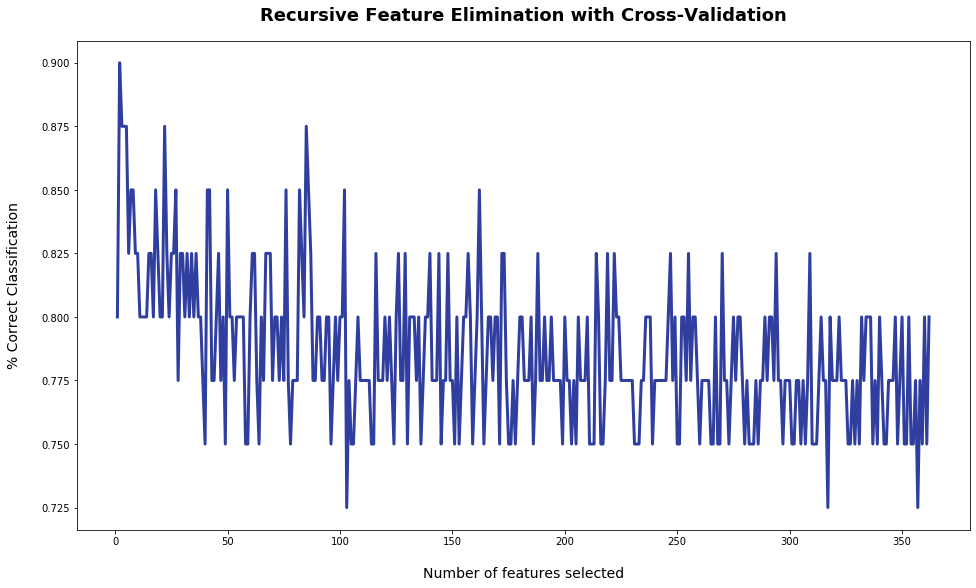

In [52]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

###### Dropping least important descriptors

In [53]:
print(np.where(rfecv.support_ == False)[0])

train.drop(train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)
test.drop(test.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36
  37  38  39  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 247 24

In [757]:
len(train.columns)

181

##### Descriptors' relevance

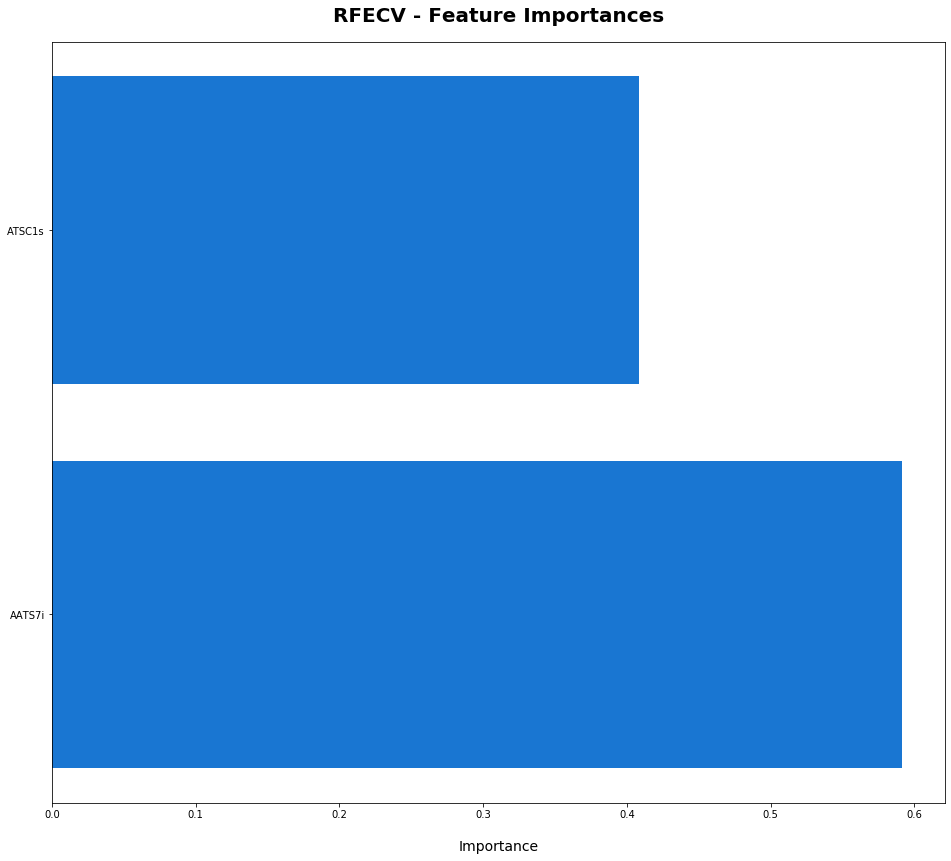

In [74]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()



### Support Vector Machine (SVM) 

#### Grid search cross-validation and SVM classificator

In [279]:
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svc = SVC()
clf = GridSearchCV(svc, param_grid = parameters)

In [280]:
clf.fit(train, ic50_train_enc_all_ligand)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [281]:
ypred = clf.predict(test)

In [282]:
print("Accuracy: {}".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

Accuracy: 0.7272727272727273


In [283]:
clf.fit(train_sc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_sc)
print("Accuracy: {} - standard".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_mmsc)
print("Accuracy: {} - MinMax".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_masc)
print("Accuracy: {} - MaxAbs".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_rsc)
print("Accuracy: {} - Robust".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_gsc)
print("Accuracy: {} - Gaussian".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_usc)
print("Accuracy: {} - Uniform".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(test_nsc)
print("Accuracy: {} - Normalized".format(metrics.accuracy_score(ic50_test_enc_all_ligand, ypred)))


Accuracy: 0.7272727272727273 - standard
Accuracy: 0.8181818181818182 - MinMax
Accuracy: 0.5454545454545454 - MaxAbs
Accuracy: 0.8181818181818182 - Robust
Accuracy: 0.7272727272727273 - Gaussian
Accuracy: 0.8181818181818182 - Uniform
Accuracy: 0.7272727272727273 - Normalized


In [286]:
scaler = Normalizer()
validate_nsc = scaler.fit_transform(validate)

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(validate_nsc)
print("Accuracy validation: {} - Normalized".format(metrics.accuracy_score(ic50_validate_enc_all_ligand, ypred)))

scaler = scaler = QuantileTransformer(output_distribution='uniform')
validate_usc = scaler.fit_transform(validate)

clf.fit(train_nsc, ic50_train_enc_all_ligand)
ypred = clf.predict(validate_usc)
print("Accuracy validation: {} - Uniform".format(metrics.accuracy_score(ic50_validate_enc_all_ligand, ypred)))

Accuracy validation: 0.6363636363636364 - Normalized
Accuracy validation: 0.7272727272727273 - Uniform


#### Grid search cross-validation and SVM regressor

In [287]:
from sklearn.svm import SVR
C_range = np.arange(0.01, 100, step=5)
gamma_range = np.arange(0.1, 10, step=2)
kernels = ["linear","sigmoid","rbf","poly"]
parameters = dict(gamma=gamma_range, C=C_range, kernel=kernels)

svr = SVR()
clf = GridSearchCV(svr, param_grid = parameters)

In [288]:
clf.fit(train, ic50_train_all_ligand)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.000e-02, 5.010e+00, 1.001e+01, 1.501e+01, 2.001e+01, 2.501e+01,
       3.001e+01, 3.501e+01, 4.001e+01, 4.501e+01, 5.001e+01, 5.501e+01,
       6.001e+01, 6.501e+01, 7.001e+01, 7.501e+01, 8.001e+01, 8.501e+01,
       9.001e+01, 9.501e+01]),
                         'gamma': array([0.1, 2.1, 4.1, 6.1, 8.1]),
                         'kernel': ['linear', 'sigmoid', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [289]:
ypred=clf.predict(test)

In [290]:
metrics.r2_score(ic50_test_all_ligand, ypred)

-0.1153928124079584

In [291]:
clf.fit(train_sc, ic50_train_all_ligand)
ypred = clf.predict(test_sc)
print("R²: {} - standard".format(metrics.r2_score(ic50_test_all_ligand, ypred)))
      
clf.fit(train_mmsc, ic50_train_all_ligand)
ypred = clf.predict(test_mmsc)
print("R²: {} - MinMax".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_masc, ic50_train_all_ligand)
ypred = clf.predict(test_masc)
print("R²: {} - MaxAbs".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_rsc, ic50_train_all_ligand)
ypred = clf.predict(test_rsc)
print("R²: {} - Robust".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_gsc, ic50_train_all_ligand)
ypred = clf.predict(test_gsc)
print("R²: {} - Gaussian".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_usc, ic50_train_all_ligand)
ypred = clf.predict(test_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(test_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_test_all_ligand, ypred)))

R²: -0.11384460328448709 - standard
R²: -0.10583169408208826 - MinMax
R²: -0.0911884375598142 - MaxAbs
R²: -0.11401523290807614 - Robust
R²: -0.08923730935707885 - Gaussian
R²: -0.09938420713336904 - Uniform
R²: -0.11597175749704292 - Normalized


In [293]:
clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(validate_nsc)
print("R²: {} - Normalized".format(metrics.r2_score(ic50_validate_all_ligands, ypred)))


clf.fit(train_nsc, ic50_train_all_ligand)
ypred = clf.predict(validate_usc)
print("R²: {} - Uniform".format(metrics.r2_score(ic50_validate_all_ligands, ypred)))

R²: 0.014544216279491762 - Normalized
R²: -2.5963115403179717 - Uniform


### Neural networks

#### Multi-Layer Perceptor Classifier (MLPC)

In [294]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)

In [295]:
mlp.fit(train,ic50_train_enc_all_ligand)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [296]:
predictions = mlp.predict(test)

In [297]:
print(confusion_matrix(ic50_test_enc_all_ligand,predictions))
print(classification_report(ic50_test_enc_all_ligand,predictions))

[[7 0]
 [3 1]]
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.25      0.40         4

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11



In [298]:
mlp.fit(train_sc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_sc)
print("Standard")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_mmsc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_mmsc)
print("----------------------------------------------")
print("MinMax")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_masc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_masc)
print("----------------------------------------------")
print("MaxAbs")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_rsc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_rsc)
print("----------------------------------------------")
print("Robust")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_gsc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_gsc)
print("----------------------------------------------")
print("Gaussian")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_usc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_usc)
print("----------------------------------------------")
print("Uniform")
print(classification_report(ic50_test_enc_all_ligand,predictions))

mlp.fit(train_nsc,ic50_train_enc_all_ligand)
predictions = mlp.predict(test_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_test_enc_all_ligand,predictions))

Standard
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.75      0.86         4

    accuracy                           0.91        11
   macro avg       0.94      0.88      0.90        11
weighted avg       0.92      0.91      0.91        11

----------------------------------------------
MinMax
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.67      1.00      0.80         4

    accuracy                           0.82        11
   macro avg       0.83      0.86      0.82        11
weighted avg       0.88      0.82      0.82        11

----------------------------------------------
MaxAbs
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.50      0.75      0.60         4

    accuracy                           0.64        11
   macro av

In [300]:
mlp.fit(train_nsc,ic50_train_enc_all_ligand)
predictions = mlp.predict(validate_nsc)
print("----------------------------------------------")
print("Normalized")
print(classification_report(ic50_validate_enc_all_ligand,predictions))

----------------------------------------------
Normalized
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.25      0.50      0.33         2

    accuracy                           0.64        11
   macro avg       0.55      0.58      0.54        11
weighted avg       0.75      0.64      0.67        11



### Gradient Boosting Classifier

#### Learning rates

A learning rate that maximizes accuracy in both training and test sets.

In [68]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(train_sc, ic50_train_enc_all_ligand)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(train_sc, ic50_train_enc_all_ligand)))
    print("Accuracy score (test): {0:.3f}".format(gb_clf.score(test_sc, ic50_test_enc_all_ligand)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.892
Accuracy score (test): 0.562

Learning rate:  0.075
Accuracy score (training): 0.973
Accuracy score (test): 0.562

Learning rate:  0.1
Accuracy score (training): 0.973
Accuracy score (test): 0.625

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (test): 0.625

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (test): 0.625

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (test): 0.625

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (test): 0.562



In [69]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(train_mmsc, ic50_train_enc_all_ligand)
predictions = gb_clf2.predict(test_mmsc)

print("Confusion Matrix:")
print(confusion_matrix(ic50_test_enc_all_ligand, predictions))

print("Classification Report")
print(classification_report(ic50_test_enc_all_ligand, predictions))

Confusion Matrix:
[[9 0]
 [2 5]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.71      0.83         7

    accuracy                           0.88        16
   macro avg       0.91      0.86      0.87        16
weighted avg       0.90      0.88      0.87        16



#### XGBoost Classifier

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [4]:
xgb_clf = XGBClassifier()

In [5]:
xgb_clf.fit(train_nsc, ic50_train_enc_all_ligand)
xgb_clf

NameError: name 'train_nsc' is not defined

In [6]:
y_pred = xgb_clf.predict(test_nsc)
predictions = [round(value) for value in y_pred]

NameError: name 'test_nsc' is not defined

In [7]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_test_enc_all_ligand, predictions)
print("Accuracy: {}%".format(accuracy * 100.0))

NameError: name 'ic50_test_enc_all_ligand' is not defined

In [8]:
y_pred = xgb_clf.predict(validate_nsc)
predictions = [round(value) for value in y_pred]

NameError: name 'validate_nsc' is not defined

In [783]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(ic50_validate_enc_all_ligand, predictions)
print("Accuracy: {}%".format(accuracy * 100.0))

Accuracy: 45.45454545454545%
